<a href="https://colab.research.google.com/github/ahmad-PH/nag-notebooks/blob/master/NAG_tripletLossExperiment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [128]:
import subprocess
def run_shell_command(cmd):
  p = subprocess.Popen(cmd, shell=True, stdout=subprocess.PIPE)
  print(str(p.communicate()[0], 'utf-8'))


def detect_env():
    import os
    if 'content' in os.listdir('/'):
      return "colab"
    else:
      return "IBM"
  
  
def create_env():
  if detect_env() == "IBM":
    return IBMEnv()
  elif detect_env() == "colab":
    return ColabEnv()


class Env:
  def get_nag_util_files(self):
      import os
      
      print("\ngetting git files ...")
      if os.path.isdir(self.python_files_path):
        os.chdir(self.python_files_path)
        run_shell_command('git pull')
        os.chdir(self.root_folder)
      else:
        run_shell_command('git clone https://github.com/ahmad-PH/nag-public.git')
      print("done.")
  

class IBMEnv(Env):
    def __init__(self):
      self.root_folder = "/root/Derakhshani/adversarial"
      self.temp_csv_path = self.root_folder + "/temp"
      self.python_files_path = self.root_folder + "/nag-public"
      self.python_files_dir = "NAG-11May-beforeDenoiser"
      
      import sys
      sys.path.append('./nag/nag_util')
      
    def get_csv_path(self):
      return self.root_folder + "/textual_notes/CSVs/" + self.save_filename
    
    def get_models_path(self):
      return self.root_folder + "/models/" + self.save_filename
      
    def setup(self):
      self.get_nag_util_files()
      
      import os; import torch;
      os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID" 
      cuda_index = 0
      os.environ['CUDA_VISIBLE_DEVICES']=str(cuda_index)
#       defaults.device = torch.device('cuda:' + str(cuda_index))
#       print('cuda:' + str(cuda_index))
#       torch.cuda.set_device('cuda:1')
      
    def load_dataset(self, compressed_name, unpacked_name):
      pass

    def load_test_dataset(self, root_folder):
      pass
    
    def set_data_path(self, path):
      self.data_path = Path(self.root_folder + '/datasets/' + path)
    
        
class ColabEnv(Env):
    def __init__(self):
      self.root_folder = '/content'
      self.temp_csv_path = self.root_folder
      self.python_files_path = self.root_folder + '/nag-public'
      self.python_files_dir = "NAG-11May-beforeDenoiser"
      self.torchvision_upgraded = False
      
    def get_csv_path(self):
      return self.root_folder + '/gdrive/My Drive/DL/textual_notes/CSVs/' + self.save_filename
    
    def get_models_path(self):
      return self.root_folder + "/gdrive/My Drive/DL/models/" + self.save_filename
        
    def setup(self):
        # ######################################################
        # # TODO remove this once torchvision 0.3 is present by
        # # default in Colab
        # ######################################################
        global torchvision_upgraded
        try:
            torchvision_upgraded
        except NameError:
          !pip uninstall -y torchvision
          !pip install https://download.pytorch.org/whl/cu100/torchvision-0.3.0-cp36-cp36m-linux_x86_64.whl
          torchvision_upgraded = True
        else:
          print("torchvision already upgraded")
          
        from google.colab import drive
        drive.mount('/content/gdrive')
        
        self.get_nag_util_files()
        
    def load_dataset(self, compressed_name, unpacked_name):
      if compressed_name not in os.listdir('.'):
        print(compressed_name + ' not found, getting it from drive')
        shutil.copyfile("/content/gdrive/My Drive/DL/{}.tar.gz".format(compressed_name), "./{}.tar.gz".format(compressed_name))

        gunzip_arg = "./{}.tar.gz".format(compressed_name)
        !gunzip -f $gunzip_arg

        tar_arg = "./{}.tar".format(compressed_name)
        !tar -xvf $tar_arg > /dev/null

        os.rename(unpacked_name, compressed_name)

    #     ls_arg = "./{}/train/n01440764".format(compressed_name)
    #     !ls $ls_arg

        !rm $tar_arg

        print("done") 
      else:
        print(compressed_name + " found")
        
    def load_test_dataset(self, root_folder):
      test_folder = root_folder + '/test/'
      if 'test' not in os.listdir(root_folder):
        print('getting test dataset from drive')
        os.mkdir(test_folder)
        for i in range(1,11):
          shutil.copy("/content/gdrive/My Drive/DL/full_test_folder/{}.zip".format(i), test_folder)
          shutil.unpack_archive(test_folder + "/{}.zip".format(i), test_folder)
          os.remove(test_folder + "/{}.zip".format(i))
          print("done with the {}th fragment".format(i))
      else:
        print('test dataset found.')
        
    def set_data_path(self, path):
      self.data_path = Path('./' + path)
        

In [129]:
env = create_env()
env.setup()


getting git files ...
Already up-to-date.

done.


In [130]:
from fastai.vision import *
from fastai.imports import *
from fastai.callbacks import *
from fastai.utils.mem import *
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.models as models
import sys; import os; import shutil

In [131]:
sys.path.append(env.python_files_path + '/' + env.python_files_dir)

from nag_util import *
import nag_util

In [132]:
# mode = "sanity_check"
mode = "normal"
# mode = "div_metric_calc"

In [133]:
if mode == "normal":
  env.load_dataset('dataset','data')
  env.set_data_path('dataset')
elif mode == "sanity_check":
  env.load_dataset('dataset_sanity_check_small', 'dataset_sanity_check_small')  
  env.set_data_path('dataset_sanity_check_small')
elif mode == "div_metric_calc":
  env.load_dataset('dataset','data')
  env.set_data_path('dataset')
  env.load_test_dataset(str(env.data_path))

In [134]:
batch_size = 8
gpu_flag = True
nag_util.batch_size = batch_size; nag_util.gpu_flag = gpu_flag;
# nag_util.set_globals(gpu_flag, batch_size)
tfms = get_transforms(do_flip=False, max_rotate=0)
data = (ImageList.from_folder(env.data_path)
        .split_by_folder(valid=('test' if mode == 'div_metric_calc' else 'valid'))
        .label_from_folder()
        .transform(tfms, size=224)
        .databunch(bs=batch_size, num_workers=1)
        .normalize(imagenet_stats))

# data.show_batch(rows=2, figsize=(5,5))

In [135]:
# model = models.resnet50
# model = models.resnet152
model = models.vgg16_bn
# model = torchvision.models.googlenet
model_name = model.__name__
z_dim = 1000

class SoftmaxWrapper(nn.Module):
  def __init__(self, m):
    super().__init__()
    self.m = m
    self.softmax = nn.Softmax(dim=-1)
    
  def forward(self, inp):
    out = self.m(inp)
    return self.softmax(out)
  
arch = SoftmaxWrapper(model(pretrained=True).cuda().eval())
nag_util.arch = arch
requires_grad(arch, False)

# vgg:
# layers = []
# blocks = [i-1 for i,o in enumerate(children(arch.features)) if isinstance(o, nn.MaxPool2d)]
# layers = [arch.features[i] for i in blocks]
# layer_weights = [1] * len(layers)

layers = [
    arch.softmax
]

layer_weights = [1.] * len(layers)

# inception:
# layers = [
#     arch.Conv2d_1a_3x3,
#     arch.Mixed_6e,
#     arch.Mixed_7a,
#     arch.fc    
# ]
# layer_weights = [1.0/4.0] * len(layers)

In [136]:
# class Gen(nn.Module):
#   def __init__(self, z_dim, gf_dim=64, y_dim = None, df_dim = 64, image_shape = [3,128,128]):
#     super(Gen, self).__init__()

#     self.bs = None
#     self.z_dim = z_dim
#     self.gf_dim = gf_dim
#     self.y_dim = y_dim
#     self.df_dim = df_dim
#     self.image_shape = image_shape

#     self.z_ = nn.Linear(self.z_dim, self.gf_dim * 7 * 4 * 4, bias=True)
#     self.z_.bias.data.fill_(0)
#     self.BN_ = nn.BatchNorm2d(self.gf_dim * 7)

#     self.CT2d_1 = deconv_layer(self.gf_dim * 8, self.gf_dim * 4, k_size = (5,5), pad = (2,2))
    
#     self.CT2d_2 = deconv_layer(self.gf_dim * 5, self.gf_dim * 2)

#     self.half = max(self.gf_dim // 2, 1) 
#     self.CT2d_3 = deconv_layer(self.gf_dim * 2 + self.half, self.gf_dim * 1)

#     self.quarter = max(self.gf_dim // 4, 1)
#     self.CT2d_4 = deconv_layer(self.gf_dim * 1 + self.quarter, self.gf_dim * 1)

#     self.eighth = max(self.gf_dim // 8, 1)
#     self.CT2d_5 = deconv_layer(self.gf_dim * 1 + self.eighth, self.gf_dim * 1)

#     # sixteenth = max(self.gf_dim // 16, 1)
#     self.CT2d_6 = deconv_layer(self.gf_dim * 1 + self.eighth, self.gf_dim * 1)

#     # sixteenth = max(self.gf_dim // 16, 1)
#     self.CT2d_7 = deconv_layer(self.gf_dim * 1 + self.eighth, 3, k_size = (5,5), s = (1,1), pad = (2,2), activation = False)

#   def randomized_deconv_layer(self, h_input, z_size_0, z_size_1, deconv_layer, expected_output_size):
#     h_input_z = self.make_z([self.bs, z_size_0, z_size_1, z_size_1])
#     h_input = torch.cat([h_input, h_input_z], dim = 1)
#     output = deconv_layer(h_input)
#     assert output.shape[2:] == (expected_output_size, expected_output_size), \
#             "Unexpected output shape at randomized_deconv_layer. expected" + \
#             "({0},{0}), got {1}".format(expected_output_size, output.shape[2:])
#     return output
  
#   def forward_z(self, z):
#     self.bs = z.shape[0]
    
#     h0 = F.relu(self.BN_(self.z_(z).contiguous().view(self.bs, -1, 4, 4)))
#     assert h0.shape[2:] == (4, 4), "Non-expected shape, it shoud be (4,4)"

#     h1 = self.randomized_deconv_layer(h0, self.gf_dim, 4, self.CT2d_1, 7)
#     h2 = self.randomized_deconv_layer(h1, self.gf_dim, 7, self.CT2d_2, 14)
#     h3 = self.randomized_deconv_layer(h2, self.half, 14, self.CT2d_3, 28)
#     h4 = self.randomized_deconv_layer(h3, self.quarter, 28, self.CT2d_4, 56)
#     h5 = self.randomized_deconv_layer(h4, self.eighth, 56, self.CT2d_5, 112)
#     h6 = self.randomized_deconv_layer(h5, self.eighth, 112, self.CT2d_6, 224)
#     h7 = self.randomized_deconv_layer(h6, self.eighth, 224, self.CT2d_7, 224)

#     ksi = 10.0
#     output_coeff = ksi / (255.0 * np.mean(imagenet_stats[1])) 
#     # this coeff scales the output to be appropriate for images that are 
#     # normalized using imagenet_stats (and are hence in the approximate [-2.5, 2.5]
#     # interval)
#     return output_coeff * torch.tanh(h7)

#   def forward(self, inputs):
#     self.bs = inputs.shape[0]
#     z = inputs.new_empty([self.bs, self.z_dim]).uniform_(-1,1).cuda()
# #     p, n = self.make_triplet_samples(z, 0.1, 0.1, 2.)
    
#     z_out = self.forward_z(z)
# #     p_out = self.forward_z(p)
# #     n_out = self.forward_z(n)
    
# #     return z_out, p_out, n_out, inputs
#     return z_out, None, None, inputs
  
#   def forward_single_z(self, z):
#     return self.forward_z(z[None]).squeeze()
           
  
#   def make_triplet_samples(self, z, margin, r2, r3):
#     positive_sample = z + self.random_vector_volume(z.shape, 0, margin).cuda() 
#     negative_sample = z + self.random_vector_volume(z.shape, r2, r3).cuda()
#     return positive_sample, negative_sample

#   def random_vector_surface(self, shape, r = 1.):
#     mat = torch.randn(size=shape).cuda()
#     norm = torch.norm(mat, p=2, dim=1, keepdim = True).cuda()
#     return (mat/norm) * r

  
#   def random_vector_volume(self, shape, inner_r, outer_r):
#     fraction = torch.empty(shape[0]).uniform_(inner_r, outer_r).cuda()
#     fraction = ((fraction / outer_r) ** (1 / shape[1])) * outer_r # volume-normalize the fraction
#     fraction.unsqueeze_(-1)
#     return self.random_vector_surface(shape, 1) * fraction

#   def make_z(self, in_shape):
#     return torch.empty(in_shape).cuda().uniform_(-1,1)


In [137]:
class Gen(nn.Module):
  def __init__(self, z_dim, gf_dim=64, y_dim = None, df_dim = 64, image_shape = [3,128,128]):
    super(Gen, self).__init__()

    self.bs = None
    self.z_dim = z_dim
    self.gf_dim = gf_dim
    self.y_dim = y_dim
    self.df_dim = df_dim
    self.image_shape = image_shape

    self.z_ = nn.Linear(self.z_dim, self.gf_dim * 7 * 4 * 4, bias=True)
    self.z_.bias.data.fill_(0)
    self.BN_ = nn.BatchNorm2d(self.gf_dim * 7)

    self.CT2d_1 = deconv_layer(self.gf_dim * 8, self.gf_dim * 4, k_size = (5,5), pad = (2,2))
    
    self.CT2d_2 = deconv_layer(self.gf_dim * 5, self.gf_dim * 2)

    self.half = max(self.gf_dim // 2, 1) 
    self.CT2d_3 = deconv_layer(self.gf_dim * 2 + self.half, self.gf_dim * 1)

    self.quarter = max(self.gf_dim // 4, 1)
    self.CT2d_4 = deconv_layer(self.gf_dim * 1 + self.quarter, self.gf_dim * 1)

    self.eighth = max(self.gf_dim // 8, 1)
    self.CT2d_5 = deconv_layer(self.gf_dim * 1 + self.eighth, self.gf_dim * 1)

    # sixteenth = max(self.gf_dim // 16, 1)
    self.CT2d_6 = deconv_layer(self.gf_dim * 1 + self.eighth, self.gf_dim * 1)

    # sixteenth = max(self.gf_dim // 16, 1)
    self.CT2d_7 = deconv_layer(self.gf_dim * 1 + self.eighth, 3, k_size = (5,5), s = (1,1), pad = (2,2), activation = False)

  def randomized_deconv_layer(self, h_input, z_size_0, z_size_1, deconv_layer, expected_output_size):
    h_input_z = self.make_z([self.bs, z_size_0, z_size_1, z_size_1])
    h_input = torch.cat([h_input, h_input_z], dim = 1)
    output = deconv_layer(h_input)
    assert output.shape[2:] == (expected_output_size, expected_output_size), \
            "Unexpected output shape at randomized_deconv_layer. expected" + \
            "({0},{0}), got {1}".format(expected_output_size, output.shape[2:])
    return output
  
  def forward_z(self, z):
    self.bs = z.shape[0]
    
    h0 = F.relu(self.BN_(self.z_(z).contiguous().view(self.bs, -1, 4, 4)))
    assert h0.shape[2:] == (4, 4), "Non-expected shape, it shoud be (4,4)"

    h1 = self.randomized_deconv_layer(h0, self.gf_dim, 4, self.CT2d_1, 7)
    h2 = self.randomized_deconv_layer(h1, self.gf_dim, 7, self.CT2d_2, 14)
    h3 = self.randomized_deconv_layer(h2, self.half, 14, self.CT2d_3, 28)
    h4 = self.randomized_deconv_layer(h3, self.quarter, 28, self.CT2d_4, 56)
    h5 = self.randomized_deconv_layer(h4, self.eighth, 56, self.CT2d_5, 112)
    h6 = self.randomized_deconv_layer(h5, self.eighth, 112, self.CT2d_6, 224)
    h7 = self.randomized_deconv_layer(h6, self.eighth, 224, self.CT2d_7, 224)

    ksi = 10.0
    output_coeff = ksi / (255.0 * np.mean(imagenet_stats[1])) 
    # this coeff scales the output to be appropriate for images that are 
    # normalized using imagenet_stats (and are hence in the approximate [-2.5, 2.5]
    # interval)
    return output_coeff * torch.tanh(h7)

  def forward(self, inputs):
    self.bs = inputs.shape[0]
    
    z = torch.zeros([self.bs, 999]).cuda()
    for i in range(self.bs):
      l = list(range(1000))
      random_label = l[np.random.randint(0,1000)]
      z[i][random_label] = 1.
    
    z_out = self.forward_z(z)
    
    return z_out, None, None, inputs, z
  
  def forward_single_z(self, z):
    return self.forward_z(z[None]).squeeze()
           
  
  def make_triplet_samples(self, z, margin, r2, r3):
    positive_sample = z + self.random_vector_volume(z.shape, 0, margin).cuda() 
    negative_sample = z + self.random_vector_volume(z.shape, r2, r3).cuda()
    return positive_sample, negative_sample

  def random_vector_surface(self, shape, r = 1.):
    mat = torch.randn(size=shape).cuda()
    norm = torch.norm(mat, p=2, dim=1, keepdim = True).cuda()
    return (mat/norm) * r

  
  def random_vector_volume(self, shape, inner_r, outer_r):
    fraction = torch.empty(shape[0]).uniform_(inner_r, outer_r).cuda()
    fraction = ((fraction / outer_r) ** (1 / shape[1])) * outer_r # volume-normalize the fraction
    fraction.unsqueeze_(-1)
    return self.random_vector_surface(shape, 1) * fraction

  def make_z(self, in_shape):
    return torch.empty(in_shape).cuda().uniform_(-1,1)


In [138]:
def tensorify(x):
  return x if isinstance(x, torch.Tensor) else torch.tensor(x)

In [158]:
def js_distance(x1, x2):
  m = 0.5 * (x1 + x2)
  return 0.5 * (F.kl_div(x1, m) + F.kl_div(x2, m))

def kl_distance(x1, x2):
  inp = torch.log(x1)
  target = x2
  return F.kl_div(inp, target, reduction='batchmean')

def distrib_distance(x1, x2):
  x1 = tensorify(x1)
  x2 = tensorify(x2)
  x1 = x1 / torch.sum(x1)
  x2 = x2 / torch.sum(x2)
  return kl_distance(x1[None], x2[None])

def distrib_distance(x1, x2):
  if not isinstance(x1, torch.Tensor): x1 = torch.tensor(x1)
  if not isinstance(x2, torch.Tensor): x2 = torch.tensor(x2)
  x1 = x1 * 100. / torch.sum(x1)
  x2 = x2 * 100. / torch.sum(x2)
#   print_big_vector(x1, 0.1)
#   print_big_vector(x2, 0.1)
  return torch.norm(x1 - x2, 2)

def distance_from_uniform(x):
  return distrib_distance(x, [1.] * len(x))

def wasserstein_distance(x1, x2):
  return torch.mean(x1 - x2)

def l1_distance(x1, x2):
  return F.l1_loss(x1, x2)

def l2_distance(x1, x2):
  return F.mse_loss(x1 * 10, x2 * 10)

def mse_loss(x1, x2):
  return F.mse_loss(x1, x2)

def cos_distance(x1, x2, dim = 1):
  return -1 * torch.mean(F.cosine_similarity(x1, x2, dim=dim))

triplet_call_cnt = 0

def triplet_loss(anchor, positive, negative, distance_func, margin):
  # max distance when using l1_distance is 2
  # max distacne when using l2-distance is sqrt(2)
#   print("anchor: ", anchor.min(), anchor.max())
  ap_dist = distance_func(anchor, positive)
  an_dist = distance_func(anchor, negative)

  global triplet_call_cnt
  triplet_call_cnt += 1
  if triplet_call_cnt % 10 in [0,1] : #and anchor.shape[1] == 1000:
#     print("a: ", end=""); print_big_vector(anchor[0])
#     print("p: ", end=""); print_big_vector(positive[0])
#     print("n: ", end=""); print_big_vector(negative[0])
#     print("ap_dist: {}, an_dist: {}".format(ap_dist, an_dist))
    print("func:{}, ap_dist: {}, an_dist: {}".format(distance_func.__name__, ap_dist, an_dist))
    
  return torch.mean(F.relu(ap_dist - an_dist + margin))

In [140]:
def diversity_loss(input, target):
#   return -1 * torch.mean(torch.pow(f_x_a-f_x_s,2))
  if input.shape[0] != batch_size:
    print("input shape: ", input.shape)
    print("target shape: ", target.shape, "\n\n")
  return torch.mean(F.cosine_similarity(
    input.view([batch_size, -1]),
    target.view([batch_size, -1]), 
  ))

# def fool_loss(input, target):
#     true_class = torch.argmax(target, dim=1).view(-1,1).long()
#     return -1 * torch.log(torch.mean(1 - input.gather(1, true_class)))

def fool_loss_old(input, target, trash):
  print("fool_loss:")
  true_class = torch.argmax(target, dim=1).view(-1,1).long()
  print(true_class)
  print("input: ", input.shape)
  a = input.gather(1, true_class)
  print(a)
  print(1 - a)
  print(torch.mean(1 - a))
  print(torch.log(torch.mean(1-a)))
  print("\n\n")
  # this is wrong! first log should be taken, THEN mean.
  return -1 * torch.log(torch.mean(1 - input.gather(1, true_class)))

fool_loss_count = 0

def fool_loss(model_output, target_labels):
  target_labels = target_labels.view(-1, 1).long().cuda()
  target_probabilities = model_output.gather(1, target_labels)
  epsilon = 1e-10
  # highest possible fool_loss is - log(1e-10) == 23
  result = torch.mean(-1 * torch.log(target_probabilities + epsilon))
  
  global fool_loss_count
  fool_loss_count += 1
  if fool_loss_count % 20 == 0:
    print("target probs {}, loss: {}: ".format(target_probabilities, result))
  
  return result


def validation(gen_output, target):
  perturbations, _, _, clean_images, _ = gen_output
  perturbed_images = clean_images + perturbations
  benign_preds = torch.argmax(arch(clean_images), 1)
  adversary_preds = torch.argmax(arch(perturbed_images), 1)
  return (benign_preds != adversary_preds).float().mean()


In [141]:
# class FeatureLoss(nn.Module):
#     def __name__(self):
#       return "feature_loss"
  
#     def __init__(self, dis, layers, layer_weights):
#         super().__init__()
        
#         # define generator here 
#         self.dis = dis
#         self.diversity_layers = layers
#         self.hooks = hook_outputs(self.diversity_layers, detach=False)
#         self.weights = layer_weights
#         self.metric_names = ["fool_loss"] + [f"div_loss_{i}" for i in range(len(layers))] + ['triplet_conv'] + ['triplet_raw'] #+ ['triplet_loss_2']# Maybe Gram
#         self.triplet_weight = 10.
#         self.triplet_weight_noise = 5.
#         self.triplet_weight_sm = 5.
        
#         self.triplet_hooks = hook_outputs([arch.m.features[4]], detach=False)
    
#     def make_features(self, x, clone=False):
#         y = self.dis(x)
#         return y, [(o.clone() if clone else o) for o in self.hooks.stored], [(o.clone() if clone else o) for o in self.triplet_hooks.stored]
    
#     #use the raw, and the conv triplet losses
#     def forward(self, inp, target):
#         sigma_B, sigma_pos, sigma_neg, X_B = inp

#         X_A = X_B + sigma_B
#         X_A_pos = X_B + sigma_pos
#         X_A_neg = X_B + sigma_neg
        
#         X_S = self.add_perturbation_shuffled(X_B, sigma_B) # Shuffled Addversarial Examples
        
#         B_Y, _, _ = self.make_features(X_B)
#         A_Y, A_feat, anchor_hook = self.make_features(X_A)
#         _, S_feat, _ = self.make_features(X_S)
#         pos_softmax, _, pos_hook = self.make_features(X_A_pos)
#         neg_softmax, _, neg_hook = self.make_features(X_A_neg)
        
#         fooling_loss =  fool_loss(A_Y, B_Y)
      
#         raw_diversity_losses = [diversity_loss(a_f, s_f) for a_f, s_f in zip(A_feat, S_feat)]
#         weighted_diversity_losses = [diversity_loss(a_f, s_f) * weight for a_f, s_f, weight in zip(A_feat, S_feat, self.weights)]
        
# #         flatten = lambda x: x.view(x.shape[0], x.shape[1], -1)
# #         raw_triplet_loss = triplet_loss(
# #           flatten(anchor_hook[0]), flatten(pos_hook[0]), flatten(neg_hook[0]), 
# #           partial(cos_distance, dim=2), 1.4
# #         )
#         raw_triplet_losses = [triplet_loss(
#           anchor_hook[0], pos_hook[0], neg_hook[0], mse_loss, 2.
#         )] + [triplet_loss(
#           sigma_B, sigma_pos, sigma_neg, l2_distance, 10.
#         )]
#         weighted_triplet_losses = [(5. * t_loss) for t_loss in raw_triplet_losses]
    
#         self.losses = [fooling_loss] + weighted_diversity_losses + weighted_triplet_losses
#         self.metrics = dict(zip(self.metric_names, [fooling_loss] + raw_diversity_losses + weighted_triplet_losses))

#         return sum(self.losses)

# #     #use two types of triplet losses
# #     def forward(self, inp, target):
# #       sigma_B, sigma_pos, sigma_neg, X_B = inp

# #       X_A = X_B + sigma_B
# #       X_A_pos = X_B + sigma_pos
# #       X_A_neg = X_B + sigma_neg 

# #       X_S = self.add_perturbation_shuffled(X_B, sigma_B) # Shuffled Addversarial Examples

# #       B_Y, _ = self.make_features(X_B)
# #       A_Y, A_feat = self.make_features(X_A)
# #       _, S_feat = self.make_features(X_S)
# #       pos_softmax, _ = self.make_features(X_A_pos)
# #       neg_softmax, _ = self.make_features(X_A_neg)

# #       fooling_loss =  fool_loss(A_Y, B_Y)

# #       raw_diversity_losses = [diversity_loss(a_f, s_f) for a_f, s_f in zip(A_feat, S_feat)]
# #       weighted_diversity_losses = [diversity_loss(a_f, s_f) * weight for a_f, s_f, weight in zip(A_feat, S_feat, self.weights)]
      
# #       raw_triplet_loss_sm = triplet_loss(A_Y, pos_softmax, neg_softmax, cos_distance, 1.4)
# #       weighted_triplet_loss_sm = raw_triplet_loss_sm * self.triplet_weight_sm
      
# #       raw_triplet_loss_noise = triplet_loss(sigma_B, sigma_pos, sigma_neg, l2_distance, 5.)
# #       weighted_triplet_loss_noise = raw_triplet_loss_noise * self.triplet_weight_noise

# #       self.losses = [fooling_loss] + weighted_diversity_losses + [weighted_triplet_loss_sm, weighted_triplet_loss_noise] 
# #       self.metrics = dict(zip(self.metric_names, [fooling_loss] + raw_diversity_losses + [weighted_triplet_loss_sm, weighted_triplet_loss_noise]))

# #       return sum(self.losses)

# #     # just fooling and diversity
# #     def forward(self, inp, target):
# #       sigma_B, sigma_pos, sigma_neg, X_B = inp

# #       X_A = X_B + sigma_B

# #       X_S = self.add_perturbation_shuffled(X_B, sigma_B) # Shuffled Addversarial Examples

# #       B_Y, _ = self.make_features(X_B)
# #       A_Y, A_feat = self.make_features(X_A)
# #       _, S_feat = self.make_features(X_S)

# #       fooling_loss =  fool_loss(A_Y, B_Y)

# #       raw_diversity_losses = [diversity_loss(a_f, s_f) for a_f, s_f in zip(A_feat, S_feat)]
# #       weighted_diversity_losses = [diversity_loss(a_f, s_f) * weight for a_f, s_f, weight in zip(A_feat, S_feat, self.weights)]

# #       self.losses = [fooling_loss] + weighted_diversity_losses
# #       self.metrics = dict(zip(self.metric_names, [fooling_loss] + raw_diversity_losses))

# #       return sum(self.losses)  
  
#     def add_perturbation_shuffled(self, inp, perturbation):
# #         j = torch.randperm(inp.shape[0])
#         j = derangement(inp.shape[0])
#         return inp.add(perturbation[j])

In [142]:
class FeatureLoss(nn.Module):
    def __name__(self):
      return "feature_loss"
  
    def __init__(self, dis, layers, layer_weights):
        super().__init__()
        
        # define generator here 
        self.dis = dis
        self.diversity_layers = layers
        self.hooks = hook_outputs(self.diversity_layers, detach=False)
        self.weights = layer_weights
        self.metric_names = ["fool_loss"] #+ [f"div_loss_{i}" for i in range(len(layers))] #maybe Gram
        
        self.triplet_hooks = hook_outputs([arch.m.features[4]], detach=False)
    
    def make_features(self, x, clone=False):
        y = self.dis(x)
        return y, [(o.clone() if clone else o) for o in self.hooks.stored]
  
    def forward(self, inp, target):
      sigma_B, _, _, X_B, z = inp

      X_A = X_B + sigma_B
      X_S = self.add_perturbation_shuffled(X_B, sigma_B) # Shuffled Addversarial Examples

      B_Y, _ = self.make_features(X_B)
      A_Y, A_feat = self.make_features(X_A)
      _, S_feat = self.make_features(X_S)

      chosen_labels = z.argmax(dim=1)
      fooling_loss =  fool_loss(A_Y, chosen_labels)

#       raw_diversity_losses = [diversity_loss(a_f, s_f) for a_f, s_f in zip(A_feat, S_feat)]
#       weighted_diversity_losses = [diversity_loss(a_f, s_f) * weight for a_f, s_f, weight in zip(A_feat, S_feat, self.weights)]

#       self.losses = [fooling_loss] + weighted_diversity_losses
#       self.metrics = dict(zip(self.metric_names, [fooling_loss] + raw_diversity_losses))

      self.losses = [fooling_loss]
      self.metrics = dict(zip(self.metric_names, [fooling_loss]))

      return sum(self.losses)
  
    def add_perturbation_shuffled(self, inp, perturbation):
#         j = torch.randperm(inp.shape[0])
        j = derangement(inp.shape[0])
        return inp.add(perturbation[j])

In [143]:
feat_loss = FeatureLoss(arch, layers, layer_weights)

In [144]:
env.save_filename = 'vgg16_25'

if Path(env.get_csv_path() + '.csv').exists(): raise FileExistsError("csv_path already exists")
if Path(env.get_models_path()).exists(): raise FileExistsError("models_path already exists")

In [145]:
learn = None; gc.collect()
csv_logger = partial(ImmediateCSVLogger, filename= env.temp_csv_path + '/' + env.save_filename)
# learn = Learner(data, Gen(z_dim=10), loss_func = feat_loss, metrics=[validation], callback_fns=LossMetrics, opt_func = optim.SGD)
# learn = Learner(data, Gen(z_dim=z_dim), loss_func = feat_loss, metrics=[validation], callback_fns=[LossMetrics, DiversityWeightsScheduler])
learn = Learner(data, Gen(z_dim=z_dim), loss_func = feat_loss, metrics=[validation], callback_fns=[LossMetrics, csv_logger])
# load_starting_point(learn, model_name, z_dim)
# random_seed(42, True)

In [146]:
# learn.lr_find(1e-6, 1000)
# learn.recorder.plot()

In [147]:
# !cp "/content/gdrive/My Drive/DL/models/vgg16_12-last.pth"  "/content/"
# learn.load('/content/vgg16_12-last')

# learn.load('/root/Derakhshani/adversarial/models/vgg16_10/vgg16_10_29')
# learn.load('/root/Derakhshani/adversarial/models/vgg16_12-last')
# learn.load('/root/Derakhshani/adversarial/models/resnet50-11_39')


In [ ]:
if mode == "sanity_check":
  print("\n\n\nWARNING: you are training on a sanity_check dataset.\n\n\n\n")
if len(learn.callback_fns) == 1:
  print("\n\n\nWARNING: you are not using the DiversityWeightsScheduler callback.\n\n\n")

  # WARNING, YOU HAVE DISABLED THE FINAL COPYING COMMANDS
    
saver_best = SaveModelCallback(learn, every='improvement', monitor='validation', name=env.save_filename + "-best")
saver_every_epoch = SaveModelCallback(learn, every='epoch', name=env.save_filename)

learn.fit(20, lr=5e-03, wd = 0., callbacks=[saver_best, saver_every_epoch])

# learn.fit_one_cycle(8, max_lr=5e-01) #mohammad's setting that got 77 validation start on resnet with diversity loss on AdaptiveAvgPool2d
# learn.fit_one_cycle(5, max_lr=2e-2) #used for vgg-19-bn
# learn.fit_one_cycle(5, max_lr=3e-3) # used for resnet50

shutil.copyfile(env.temp_csv_path + '/' + env.save_filename + ".csv", env.get_csv_path() + '.csv')
shutil.copytree(env.data_path/"models", env.get_models_path())
shutil.rmtree(env.data_path/"models")

# shutil.copyfile("/content/dataset/models/" + save_filename + "-best.pth", "/content/gdrive/My Drive/DL/models/" + save_filename + ".pth")

epoch,train_loss,valid_loss,validation,fool_loss,time
0,10.023139,10.333879,0.724000,10.333884,04:24
1,9.706777,9.957664,0.743000,9.957667,04:24
2,9.389208,9.563589,0.746000,9.563589,04:26
3,9.137069,9.417316,0.754000,9.417315,04:28
4,8.840109,9.091180,0.761000,9.091179,04:24
5,8.686968,8.852576,0.757000,8.852576,04:27
6,8.480461,8.677320,0.772000,8.677320,04:22
7,8.264995,8.463314,0.758000,8.463315,04:22
8,7.985019,8.423385,0.762000,8.423384,04:24
9,8.059684,8.179901,0.771000,8.179903,04:23


target probs tensor([[6.6915e-08],
        [1.9376e-08],
        [1.0200e-08],
        [1.1336e-07],
        [3.3651e-07],
        [4.3043e-06],
        [1.8414e-08],
        [1.8943e-05]], device='cuda:0', grad_fn=<GatherBackward>), loss: 15.574292182922363: 
target probs tensor([[1.1042e-06],
        [4.4175e-08],
        [4.5569e-04],
        [1.8614e-06],
        [4.7840e-04],
        [9.0945e-04],
        [6.7228e-08],
        [1.4828e-04]], device='cuda:0', grad_fn=<GatherBackward>), loss: 11.439352035522461: 
target probs tensor([[9.1689e-06],
        [4.3836e-07],
        [5.1739e-06],
        [2.8263e-12],
        [2.4449e-06],
        [2.6491e-09],
        [1.0692e-05],
        [5.1388e-05]], device='cuda:0', grad_fn=<GatherBackward>), loss: 14.420638084411621: 
target probs tensor([[1.7946e-04],
        [8.7593e-10],
        [1.0661e-05],
        [6.5488e-11],
        [7.2052e-09],
        [7.5382e-07],
        [5.9327e-07],
        [8.4366e-05]], device='cuda:0', grad_fn=<G

target probs tensor([[1.9138e-06],
        [7.4319e-05],
        [1.1137e-05],
        [1.2216e-06],
        [1.4173e-05],
        [1.2272e-05],
        [1.2687e-04],
        [1.2807e-03]], device='cuda:0', grad_fn=<GatherBackward>), loss: 10.724885940551758: 
target probs tensor([[3.8871e-04],
        [1.4516e-03],
        [2.4064e-03],
        [1.3136e-04],
        [5.5965e-06],
        [4.2754e-06],
        [2.1733e-04],
        [2.9180e-06]], device='cuda:0', grad_fn=<GatherBackward>), loss: 9.373699188232422: 
target probs tensor([[8.6935e-05],
        [1.1401e-06],
        [3.2691e-05],
        [4.0479e-07],
        [5.3152e-06],
        [3.0110e-06],
        [7.1900e-05],
        [7.8654e-06]], device='cuda:0', grad_fn=<GatherBackward>), loss: 11.779265403747559: 
target probs tensor([[6.5081e-05],
        [8.1821e-05],
        [4.5177e-05],
        [8.0909e-06],
        [1.9701e-04],
        [1.1144e-02],
        [6.7468e-04],
        [7.1245e-07]], device='cuda:0', grad_fn=<Ga

target probs tensor([[5.4879e-05],
        [3.8060e-04],
        [1.9911e-04],
        [1.1348e-04],
        [2.4245e-05],
        [8.4209e-04],
        [6.4254e-05],
        [7.2814e-04]], device='cuda:0', grad_fn=<GatherBackward>), loss: 8.73428726196289: 
target probs tensor([[4.1522e-05],
        [6.6259e-06],
        [1.1398e-03],
        [1.3860e-05],
        [4.0663e-06],
        [2.9315e-04],
        [8.2525e-05],
        [1.4617e-03]], device='cuda:0', grad_fn=<GatherBackward>), loss: 9.556926727294922: 
target probs tensor([[1.0101e-04],
        [1.3122e-03],
        [1.5623e-06],
        [6.1759e-04],
        [3.1170e-05],
        [8.2194e-04],
        [7.0850e-05],
        [5.0264e-03]], device='cuda:0', grad_fn=<GatherBackward>), loss: 8.615400314331055: 
target probs tensor([[2.8017e-08],
        [8.2017e-07],
        [2.2649e-04],
        [1.0838e-05],
        [6.6244e-04],
        [3.1932e-05],
        [4.4398e-06],
        [5.0443e-06]], device='cuda:0', grad_fn=<Gathe

target probs tensor([[1.8605e-04],
        [4.2108e-04],
        [6.4135e-03],
        [1.7014e-06],
        [1.8968e-03],
        [1.2632e-03],
        [1.8094e-03],
        [2.0322e-06]], device='cuda:0', grad_fn=<GatherBackward>), loss: 8.38228988647461: 
target probs tensor([[4.2381e-06],
        [4.7127e-04],
        [2.7148e-07],
        [5.2673e-05],
        [4.0399e-04],
        [3.6236e-05],
        [4.6889e-05],
        [6.2354e-05]], device='cuda:0', grad_fn=<GatherBackward>), loss: 10.336479187011719: 
target probs tensor([[1.8727e-03],
        [5.5512e-05],
        [2.5328e-04],
        [1.0053e-04],
        [3.8231e-06],
        [2.1705e-04],
        [6.1738e-06],
        [5.9996e-05]], device='cuda:0', grad_fn=<GatherBackward>), loss: 9.523942947387695: 
target probs tensor([[2.3043e-04],
        [1.1620e-04],
        [2.7311e-06],
        [2.7824e-06],
        [9.9693e-07],
        [4.3398e-04],
        [6.3006e-05],
        [3.7051e-05]], device='cuda:0', grad_fn=<Gath

target probs tensor([[1.6156e-03],
        [2.3194e-07],
        [1.8669e-05],
        [2.9175e-03],
        [1.3669e-05],
        [4.9516e-03],
        [3.2592e-06],
        [5.3754e-05]], device='cuda:0', grad_fn=<GatherBackward>), loss: 9.675443649291992: 
target probs tensor([[5.6182e-05],
        [4.0648e-05],
        [1.3636e-03],
        [5.3003e-04],
        [3.5446e-05],
        [2.0412e-04],
        [2.2010e-05],
        [7.9390e-05]], device='cuda:0', grad_fn=<GatherBackward>), loss: 9.118387222290039: 
target probs tensor([[4.7685e-03],
        [5.6162e-06],
        [1.6137e-03],
        [2.4779e-03],
        [3.2148e-06],
        [5.7883e-05],
        [1.3539e-02],
        [3.5513e-08]], device='cuda:0', grad_fn=<GatherBackward>), loss: 9.215331077575684: 
target probs tensor([[1.0291e-04],
        [1.9294e-05],
        [6.6750e-07],
        [2.2527e-06],
        [1.8414e-05],
        [4.7825e-04],
        [1.5647e-04],
        [8.2475e-06]], device='cuda:0', grad_fn=<Gath

target probs tensor([[3.9576e-05],
        [1.4441e-04],
        [1.4453e-04],
        [1.1823e-03],
        [6.6670e-04],
        [6.4210e-07],
        [3.4864e-05],
        [3.6529e-04]], device='cuda:0', grad_fn=<GatherBackward>), loss: 9.289100646972656: 
target probs tensor([[1.9546e-05],
        [3.9423e-03],
        [3.1373e-04],
        [2.6225e-05],
        [1.3538e-03],
        [4.6517e-04],
        [6.8449e-06],
        [2.3233e-04]], device='cuda:0', grad_fn=<GatherBackward>), loss: 8.691482543945312: 
target probs tensor([[1.2267e-05],
        [5.7511e-05],
        [3.5215e-04],
        [3.3241e-03],
        [2.0256e-05],
        [6.6278e-04],
        [2.6583e-04],
        [5.5564e-03]], device='cuda:0', grad_fn=<GatherBackward>), loss: 8.285215377807617: 
target probs tensor([[1.1722e-04],
        [3.4550e-04],
        [1.7780e-04],
        [1.7184e-03],
        [2.1470e-06],
        [4.9333e-03],
        [1.0323e-05],
        [1.4416e-04]], device='cuda:0', grad_fn=<Gath

target probs tensor([[2.2075e-04],
        [2.6767e-03],
        [4.0039e-03],
        [2.0914e-04],
        [7.2506e-05],
        [3.7219e-05],
        [6.6509e-05],
        [6.5069e-05]], device='cuda:0', grad_fn=<GatherBackward>), loss: 8.41542911529541: 
target probs tensor([[3.7736e-03],
        [7.8744e-05],
        [2.4522e-04],
        [7.5925e-06],
        [6.3240e-03],
        [2.6699e-11],
        [5.0806e-06],
        [9.2339e-06]], device='cuda:0', grad_fn=<GatherBackward>), loss: 10.845756530761719: 
target probs tensor([[6.0307e-08],
        [1.0500e-03],
        [2.1620e-04],
        [1.3216e-05],
        [2.9806e-05],
        [9.3382e-05],
        [4.2094e-05],
        [6.0886e-05]], device='cuda:0', grad_fn=<GatherBackward>), loss: 10.329519271850586: 
target probs tensor([[6.4349e-05],
        [2.3896e-06],
        [8.9259e-04],
        [7.7352e-05],
        [8.8642e-03],
        [1.5502e-03],
        [4.2055e-05],
        [2.7827e-04]], device='cuda:0', grad_fn=<Gat

target probs tensor([[1.6187e-04],
        [1.9602e-04],
        [3.3121e-03],
        [4.8340e-06],
        [1.0476e-04],
        [1.2114e-04],
        [6.0527e-09],
        [3.1130e-05]], device='cuda:0', grad_fn=<GatherBackward>), loss: 10.335269927978516: 
target probs tensor([[8.7801e-05],
        [5.9915e-04],
        [5.2272e-04],
        [4.2839e-05],
        [1.1144e-03],
        [2.5747e-04],
        [1.2703e-04],
        [7.4290e-04]], device='cuda:0', grad_fn=<GatherBackward>), loss: 8.201882362365723: 
target probs tensor([[1.3629e-03],
        [1.2830e-03],
        [4.4306e-04],
        [3.1097e-04],
        [1.6904e-04],
        [3.3559e-04],
        [4.5284e-05],
        [2.2648e-05]], device='cuda:0', grad_fn=<GatherBackward>), loss: 8.304655075073242: 
target probs tensor([[4.5737e-06],
        [7.2317e-04],
        [1.0627e-05],
        [3.0898e-04],
        [4.6815e-05],
        [7.1638e-04],
        [4.0373e-03],
        [6.0519e-05]], device='cuda:0', grad_fn=<Gat

target probs tensor([[1.1958e-05],
        [2.2217e-08],
        [8.9066e-03],
        [8.5522e-05],
        [3.3498e-04],
        [1.8168e-05],
        [3.8640e-07],
        [8.1968e-06]], device='cuda:0', grad_fn=<GatherBackward>), loss: 11.05435562133789: 
target probs tensor([[4.1086e-03],
        [2.8305e-05],
        [2.4687e-07],
        [3.3257e-03],
        [3.1744e-04],
        [3.8661e-03],
        [1.7106e-07],
        [4.5621e-07]], device='cuda:0', grad_fn=<GatherBackward>), loss: 10.0848388671875: 
target probs tensor([[6.5743e-02],
        [9.6203e-05],
        [4.6205e-05],
        [7.6997e-04],
        [8.5178e-04],
        [1.3110e-04],
        [3.4094e-04],
        [3.6006e-03]], device='cuda:0', grad_fn=<GatherBackward>), loss: 7.342599868774414: 
target probs tensor([[4.8795e-05],
        [1.6605e-05],
        [1.7270e-04],
        [2.9342e-03],
        [9.7461e-04],
        [2.5729e-06],
        [1.0567e-03],
        [6.9263e-05]], device='cuda:0', grad_fn=<Gathe

target probs tensor([[3.5779e-05],
        [1.5305e-07],
        [2.2199e-04],
        [4.1928e-04],
        [7.2314e-06],
        [1.3697e-03],
        [1.6451e-04],
        [7.1652e-03]], device='cuda:0', grad_fn=<GatherBackward>), loss: 9.275139808654785: 
target probs tensor([[2.8222e-03],
        [6.3726e-05],
        [8.7601e-03],
        [8.5587e-06],
        [1.0372e-03],
        [5.1326e-04],
        [1.4621e-04],
        [2.5315e-04]], device='cuda:0', grad_fn=<GatherBackward>), loss: 7.936906814575195: 
target probs tensor([[1.3997e-04],
        [7.3736e-04],
        [1.6226e-03],
        [2.7527e-04],
        [2.4288e-04],
        [3.1537e-05],
        [1.6151e-04],
        [7.6418e-04]], device='cuda:0', grad_fn=<GatherBackward>), loss: 8.162860870361328: 
target probs tensor([[3.9540e-04],
        [8.7839e-03],
        [3.2253e-06],
        [6.3775e-04],
        [3.4207e-03],
        [3.3276e-04],
        [1.7236e-03],
        [3.2960e-06]], device='cuda:0', grad_fn=<Gath

target probs tensor([[4.6274e-06],
        [8.4579e-04],
        [2.7466e-06],
        [8.0173e-04],
        [9.5657e-03],
        [1.4519e-02],
        [8.8108e-04],
        [1.3169e-03]], device='cuda:0', grad_fn=<GatherBackward>), loss: 7.730162620544434: 
target probs tensor([[3.1913e-04],
        [1.5562e-05],
        [2.6616e-04],
        [1.0947e-03],
        [6.6644e-05],
        [3.0996e-05],
        [2.6997e-05],
        [6.5162e-05]], device='cuda:0', grad_fn=<GatherBackward>), loss: 9.290680885314941: 
target probs tensor([[1.4585e-04],
        [4.1100e-04],
        [2.9393e-03],
        [1.5481e-03],
        [1.2131e-03],
        [8.3690e-04],
        [5.2503e-04],
        [4.6225e-05]], device='cuda:0', grad_fn=<GatherBackward>), loss: 7.5330586433410645: 
target probs tensor([[9.5664e-04],
        [4.1426e-04],
        [6.9252e-04],
        [3.1101e-04],
        [3.4388e-03],
        [6.3023e-05],
        [5.6279e-04],
        [5.4767e-05]], device='cuda:0', grad_fn=<Gat

target probs tensor([[0.0046],
        [0.0002],
        [0.0028],
        [0.0005],
        [0.0004],
        [0.0003],
        [0.0004],
        [0.0003]], device='cuda:0', grad_fn=<GatherBackward>), loss: 7.450094223022461: 
target probs tensor([[1.6730e-03],
        [4.3437e-05],
        [2.3020e-03],
        [4.5371e-04],
        [4.0105e-07],
        [9.9981e-05],
        [3.0806e-05],
        [3.9989e-04]], device='cuda:0', grad_fn=<GatherBackward>), loss: 9.045116424560547: 
target probs tensor([[1.7474e-04],
        [2.0389e-04],
        [8.0931e-13],
        [2.2152e-05],
        [5.3749e-03],
        [4.0947e-05],
        [2.5837e-03],
        [1.2511e-04]], device='cuda:0', grad_fn=<GatherBackward>), loss: 10.14494514465332: 
target probs tensor([[1.3386e-04],
        [1.3912e-03],
        [5.6929e-05],
        [4.2789e-03],
        [3.8075e-05],
        [2.1613e-03],
        [4.5072e-04],
        [1.0165e-03]], device='cuda:0', grad_fn=<GatherBackward>), loss: 7.7041392326

target probs tensor([[1.8769e-04],
        [1.0323e-04],
        [3.5491e-04],
        [2.2797e-03],
        [5.8233e-06],
        [1.4207e-03],
        [7.6938e-05],
        [1.6706e-03]], device='cuda:0', grad_fn=<GatherBackward>), loss: 8.282987594604492: 
target probs tensor([[2.3345e-03],
        [3.5411e-04],
        [3.4126e-03],
        [2.7850e-04],
        [6.2636e-06],
        [1.8748e-03],
        [1.3824e-05],
        [4.2179e-04]], device='cuda:0', grad_fn=<GatherBackward>), loss: 8.136552810668945: 
target probs tensor([[1.9534e-03],
        [1.7964e-03],
        [2.7894e-04],
        [3.4250e-02],
        [5.8763e-04],
        [3.0542e-05],
        [2.0350e-05],
        [2.8568e-04]], device='cuda:0', grad_fn=<GatherBackward>), loss: 7.6147050857543945: 
target probs tensor([[2.1521e-03],
        [1.6728e-04],
        [1.1793e-07],
        [7.2882e-06],
        [1.4465e-02],
        [5.9472e-05],
        [6.8740e-06],
        [4.0051e-03]], device='cuda:0', grad_fn=<Gat

target probs tensor([[6.2778e-04],
        [9.9403e-05],
        [3.4970e-04],
        [8.5572e-05],
        [3.0954e-11],
        [3.3932e-03],
        [7.1709e-06],
        [5.8081e-05]], device='cuda:0', grad_fn=<GatherBackward>), loss: 10.494441032409668: 
target probs tensor([[5.1943e-04],
        [1.6316e-05],
        [1.4323e-03],
        [5.3190e-05],
        [1.8423e-01],
        [1.3199e-05],
        [1.1858e-04],
        [1.7848e-08]], device='cuda:0', grad_fn=<GatherBackward>), loss: 9.347355842590332: 
target probs tensor([[1.9678e-04],
        [2.3171e-04],
        [2.5393e-02],
        [1.0217e-04],
        [4.7878e-04],
        [9.3967e-03],
        [3.5917e-05],
        [5.2182e-06]], device='cuda:0', grad_fn=<GatherBackward>), loss: 8.059366226196289: 
target probs tensor([[6.7685e-04],
        [1.9414e-05],
        [1.2459e-03],
        [1.8906e-04],
        [4.7608e-06],
        [2.6694e-04],
        [4.4503e-05],
        [3.9214e-04]], device='cuda:0', grad_fn=<Gat

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



target probs tensor([[2.2580e-03],
        [4.8672e-04],
        [3.0879e-05],
        [2.3348e-03],
        [5.6093e-03],
        [2.8244e-04],
        [8.1840e-05],
        [3.4854e-05]], device='cuda:0', grad_fn=<GatherBackward>), loss: 7.899603843688965: 
target probs tensor([[2.1482e-04],
        [1.1947e-02],
        [1.0549e-02],
        [3.1807e-06],
        [8.1181e-05],
        [1.9111e-03],
        [1.5581e-04],
        [1.1726e-03]], device='cuda:0', grad_fn=<GatherBackward>), loss: 7.659675598144531: 
target probs tensor([[0.0016],
        [0.0002],
        [0.0013],
        [0.0601],
        [0.0001],
        [0.0123],
        [0.0010],
        [0.0045]], device='cuda:0', grad_fn=<GatherBackward>), loss: 6.266063690185547: 
target probs tensor([[2.9152e-06],
        [2.8698e-03],
        [1.1305e-05],
        [4.8466e-08],
        [3.1075e-05],
        [2.8960e-04],
        [1.4099e-03],
        [5.7824e-03]], device='cuda:0', grad_fn=<GatherBackward>), loss: 9.6341133117

target probs tensor([[8.4253e-04],
        [4.6068e-04],
        [2.8485e-05],
        [1.0787e-02],
        [2.2706e-05],
        [1.7286e-04],
        [1.4409e-04],
        [4.3905e-05]], device='cuda:0', grad_fn=<GatherBackward>), loss: 8.498992919921875: 
target probs tensor([[0.0003],
        [0.0121],
        [0.0013],
        [0.0003],
        [0.0037],
        [0.0071],
        [0.0094],
        [0.0054]], device='cuda:0', grad_fn=<GatherBackward>), loss: 5.956204414367676: 
target probs tensor([[1.1099e-04],
        [3.7677e-05],
        [3.2545e-04],
        [2.1663e-05],
        [8.6593e-05],
        [5.6031e-05],
        [4.9503e-04],
        [5.8772e-03]], device='cuda:0', grad_fn=<GatherBackward>), loss: 8.744282722473145: 
target probs tensor([[4.9821e-06],
        [1.5532e-03],
        [1.9042e-10],
        [5.6969e-07],
        [5.2613e-06],
        [3.1884e-06],
        [1.4819e-04],
        [4.0908e-03]], device='cuda:0', grad_fn=<GatherBackward>), loss: 11.767728805

target probs tensor([[0.0002],
        [0.0013],
        [0.0003],
        [0.0029],
        [0.0022],
        [0.0234],
        [0.0013],
        [0.0053]], device='cuda:0', grad_fn=<GatherBackward>), loss: 6.391195774078369: 
target probs tensor([[3.9196e-04],
        [1.0521e-03],
        [3.0280e-03],
        [8.3345e-06],
        [2.6920e-04],
        [6.7047e-07],
        [1.7318e-03],
        [9.8345e-04]], device='cuda:0', grad_fn=<GatherBackward>), loss: 8.489310264587402: 
target probs tensor([[7.2729e-04],
        [4.4632e-05],
        [1.6632e-04],
        [1.1260e-03],
        [1.6407e-03],
        [1.9910e-04],
        [9.3626e-06],
        [5.8442e-05]], device='cuda:0', grad_fn=<GatherBackward>), loss: 8.624320983886719: 
target probs tensor([[1.8119e-03],
        [1.9569e-02],
        [1.5334e-03],
        [6.3239e-05],
        [2.1216e-02],
        [1.9936e-05],
        [2.3852e-03],
        [3.7183e-03]], device='cuda:0'), loss: 6.588123321533203: 
target probs tenso

target probs tensor([[2.6441e-05],
        [2.0035e-04],
        [1.9406e-05],
        [2.1918e-04],
        [6.8245e-04],
        [1.9207e-02],
        [1.8689e-03],
        [3.4987e-04]], device='cuda:0', grad_fn=<GatherBackward>), loss: 7.976770401000977: 
target probs tensor([[6.8486e-06],
        [3.1004e-03],
        [4.4094e-03],
        [4.2319e-04],
        [6.3296e-05],
        [2.9364e-06],
        [1.7947e-05],
        [9.0357e-03]], device='cuda:0', grad_fn=<GatherBackward>), loss: 8.61250114440918: 
target probs tensor([[0.0004],
        [0.0026],
        [0.0007],
        [0.0114],
        [0.0004],
        [0.0004],
        [0.0145],
        [0.0005]], device='cuda:0', grad_fn=<GatherBackward>), loss: 6.609891891479492: 
target probs tensor([[8.5921e-06],
        [2.1725e-05],
        [2.9201e-04],
        [6.1838e-04],
        [3.1202e-04],
        [2.4182e-04],
        [9.2995e-05],
        [1.7933e-04]], device='cuda:0', grad_fn=<GatherBackward>), loss: 9.02972793579

target probs tensor([[7.4814e-03],
        [5.6314e-09],
        [9.3813e-03],
        [6.5520e-03],
        [1.6360e-04],
        [1.7596e-03],
        [3.9622e-05],
        [6.7289e-04]], device='cuda:0'), loss: 8.258809089660645: 
target probs tensor([[1.3733e-07],
        [4.5555e-05],
        [1.0304e-06],
        [1.3870e-03],
        [7.9670e-04],
        [1.9676e-05],
        [1.6632e-03],
        [9.8110e-05]], device='cuda:0'), loss: 9.970306396484375: 
target probs tensor([[7.8194e-06],
        [1.4928e-03],
        [2.5161e-04],
        [2.4156e-04],
        [6.9579e-04],
        [1.3471e-03],
        [2.6367e-03],
        [2.2738e-03]], device='cuda:0', grad_fn=<GatherBackward>), loss: 7.598349094390869: 
target probs tensor([[5.8425e-09],
        [5.9948e-10],
        [2.1255e-04],
        [8.3943e-04],
        [2.4095e-03],
        [1.1935e-04],
        [8.9296e-03],
        [2.2567e-05]], device='cuda:0', grad_fn=<GatherBackward>), loss: 10.755014419555664: 
target prob

target probs tensor([[6.9920e-06],
        [4.2545e-03],
        [6.0993e-03],
        [1.8669e-04],
        [4.5458e-03],
        [1.2925e-03],
        [6.6077e-04],
        [1.3844e-03]], device='cuda:0', grad_fn=<GatherBackward>), loss: 7.120687484741211: 
target probs tensor([[4.4943e-04],
        [8.0829e-03],
        [1.1829e-03],
        [5.5050e-04],
        [7.0637e-05],
        [6.8949e-03],
        [3.8585e-04],
        [1.0484e-04]], device='cuda:0', grad_fn=<GatherBackward>), loss: 7.291011333465576: 
target probs tensor([[2.2842e-05],
        [1.3067e-02],
        [3.5734e-04],
        [6.9078e-05],
        [8.4869e-04],
        [1.7060e-04],
        [9.2800e-05],
        [7.5039e-03]], device='cuda:0', grad_fn=<GatherBackward>), loss: 7.808385372161865: 
target probs tensor([[1.7300e-04],
        [3.0348e-03],
        [3.5020e-04],
        [2.5932e-03],
        [3.1024e-04],
        [1.3032e-03],
        [3.1180e-03],
        [4.9786e-06]], device='cuda:0', grad_fn=<Gath

target probs tensor([[2.1699e-03],
        [3.8155e-03],
        [1.0223e-04],
        [4.1471e-03],
        [4.3348e-04],
        [1.7747e-02],
        [5.0331e-03],
        [2.9298e-01]], device='cuda:0', grad_fn=<GatherBackward>), loss: 5.583735942840576: 
target probs tensor([[9.3078e-04],
        [1.6313e-04],
        [1.5877e-03],
        [1.5252e-05],
        [4.7587e-06],
        [2.9547e-04],
        [3.4517e-02],
        [5.7227e-02]], device='cuda:0', grad_fn=<GatherBackward>), loss: 7.480772018432617: 
target probs tensor([[4.7032e-03],
        [6.7897e-04],
        [1.6088e-03],
        [2.9842e-07],
        [1.2524e-03],
        [2.9552e-03],
        [1.3828e-03],
        [7.2042e-04]], device='cuda:0', grad_fn=<GatherBackward>), loss: 7.554660797119141: 
target probs tensor([[5.1220e-04],
        [1.8954e-03],
        [1.2675e-04],
        [3.3742e-04],
        [2.3344e-04],
        [2.9061e-05],
        [1.9834e-03],
        [1.0365e-05]], device='cuda:0', grad_fn=<Gath

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



target probs tensor([[0.0343],
        [0.0005],
        [0.0007],
        [0.0037],
        [0.0007],
        [0.0118],
        [0.0006],
        [0.0356]], device='cuda:0', grad_fn=<GatherBackward>), loss: 5.777276992797852: 
target probs tensor([[3.3415e-03],
        [2.1404e-04],
        [3.6331e-03],
        [2.1696e-01],
        [1.2719e-03],
        [2.2681e-03],
        [1.8246e-03],
        [3.7017e-03]], device='cuda:0', grad_fn=<GatherBackward>), loss: 5.744723320007324: 
target probs tensor([[0.0009],
        [0.0045],
        [0.0064],
        [0.0151],
        [0.0062],
        [0.0016],
        [0.0027],
        [0.0031]], device='cuda:0', grad_fn=<GatherBackward>), loss: 5.607069969177246: 
target probs tensor([[7.7027e-03],
        [1.6041e-03],
        [3.2784e-04],
        [3.4560e-04],
        [7.6538e-06],
        [1.0395e-04],
        [1.4267e-03],
        [3.1001e-02]], device='cuda:0', grad_fn=<GatherBackward>), loss: 7.284084796905518: 
target probs tensor([[0.

target probs tensor([[2.2322e-02],
        [4.3688e-04],
        [1.7919e-03],
        [2.0557e-05],
        [1.7497e-06],
        [1.4796e-04],
        [2.5957e-04],
        [4.0457e-03]], device='cuda:0', grad_fn=<GatherBackward>), loss: 8.062005996704102: 
target probs tensor([[3.8947e-05],
        [9.0791e-05],
        [1.8948e-03],
        [1.2173e-04],
        [2.9185e-03],
        [1.9900e-04],
        [5.9770e-03],
        [5.5875e-05]], device='cuda:0', grad_fn=<GatherBackward>), loss: 8.001717567443848: 
target probs tensor([[0.0007],
        [0.0006],
        [0.0146],
        [0.0005],
        [0.0006],
        [0.0028],
        [0.0022],
        [0.0013]], device='cuda:0', grad_fn=<GatherBackward>), loss: 6.585499286651611: 
target probs tensor([[0.0086],
        [0.0030],
        [0.0321],
        [0.0214],
        [0.0035],
        [0.0072],
        [0.0010],
        [0.0001]], device='cuda:0', grad_fn=<GatherBackward>), loss: 5.532950401306152: 
target probs tensor([[6.

target probs tensor([[1.8693e-05],
        [2.6419e-06],
        [2.4316e-02],
        [4.9006e-05],
        [1.2418e-03],
        [5.1498e-04],
        [2.1522e-04],
        [1.2831e-03]], device='cuda:0', grad_fn=<GatherBackward>), loss: 8.342056274414062: 
target probs tensor([[3.2678e-03],
        [3.8666e-05],
        [3.1649e-08],
        [6.2019e-05],
        [2.0807e-03],
        [1.1347e-04],
        [2.5885e-05],
        [1.3958e-01]], device='cuda:0', grad_fn=<GatherBackward>), loss: 8.82845401763916: 
target probs tensor([[0.0013],
        [0.0041],
        [0.0028],
        [0.0016],
        [0.0047],
        [0.0003],
        [0.0006],
        [0.0014]], device='cuda:0', grad_fn=<GatherBackward>), loss: 6.514657497406006: 
target probs tensor([[2.0944e-02],
        [1.6633e-02],
        [6.2122e-08],
        [2.2911e-02],
        [3.7401e-04],
        [8.0265e-03],
        [4.1626e-04],
        [1.3766e-04]], device='cuda:0', grad_fn=<GatherBackward>), loss: 7.21527051925

target probs tensor([[9.0755e-03],
        [9.1548e-06],
        [2.3623e-05],
        [1.5521e-02],
        [1.7139e-03],
        [9.4427e-03],
        [3.7292e-04],
        [4.1986e-03]], device='cuda:0', grad_fn=<GatherBackward>), loss: 6.940115928649902: 
target probs tensor([[0.0003],
        [0.0111],
        [0.0171],
        [0.0018],
        [0.0383],
        [0.0137],
        [0.0015],
        [0.0028]], device='cuda:0', grad_fn=<GatherBackward>), loss: 5.3793253898620605: 
target probs tensor([[4.6897e-03],
        [9.6737e-02],
        [1.5059e-04],
        [1.5041e-02],
        [1.0266e-06],
        [2.9905e-03],
        [1.8162e-03],
        [1.5302e-04]], device='cuda:0', grad_fn=<GatherBackward>), loss: 6.924194812774658: 
target probs tensor([[5.4466e-04],
        [1.9413e-07],
        [4.3443e-04],
        [5.6881e-05],
        [1.0111e-04],
        [4.9352e-05],
        [7.5539e-09],
        [1.1574e-02]], device='cuda:0', grad_fn=<GatherBackward>), loss: 10.34356117

target probs tensor([[1.8584e-05],
        [2.8328e-03],
        [1.7710e-04],
        [2.2536e-03],
        [1.5008e-03],
        [1.1122e-03],
        [2.6147e-03],
        [1.8642e-04]], device='cuda:0', grad_fn=<GatherBackward>), loss: 7.416379451751709: 
target probs tensor([[3.8333e-05],
        [3.9337e-07],
        [2.2173e-02],
        [5.7476e-04],
        [1.5310e-03],
        [2.9279e-05],
        [1.5108e-04],
        [1.9042e-03]], device='cuda:0', grad_fn=<GatherBackward>), loss: 8.521217346191406: 
target probs tensor([[0.0226],
        [0.0072],
        [0.0001],
        [0.0062],
        [0.0002],
        [0.0009],
        [0.0002],
        [0.0191]], device='cuda:0', grad_fn=<GatherBackward>), loss: 6.379554748535156: 
target probs tensor([[1.5125e-03],
        [4.3897e-04],
        [1.0313e-02],
        [2.6205e-07],
        [7.9517e-04],
        [5.1958e-04],
        [5.7643e-04],
        [1.2260e-06]], device='cuda:0', grad_fn=<GatherBackward>), loss: 8.7154369354

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



target probs tensor([[6.9536e-03],
        [4.1296e-05],
        [6.7081e-04],
        [1.1798e-03],
        [2.0189e-02],
        [1.5443e-03],
        [1.2059e-01],
        [2.2784e-02]], device='cuda:0', grad_fn=<GatherBackward>), loss: 5.673192024230957: 
target probs tensor([[1.5988e-05],
        [3.4159e-03],
        [2.1996e-04],
        [2.8885e-02],
        [3.3549e-04],
        [5.2788e-04],
        [5.1686e-07],
        [3.2337e-03]], device='cuda:0', grad_fn=<GatherBackward>), loss: 8.055679321289062: 
target probs tensor([[9.8472e-02],
        [3.9708e-03],
        [9.6092e-03],
        [2.5848e-03],
        [3.7298e-04],
        [5.5396e-04],
        [9.2091e-10],
        [1.3396e-03]], device='cuda:0', grad_fn=<GatherBackward>), loss: 7.645030975341797: 
target probs tensor([[2.0360e-03],
        [3.4617e-03],
        [4.8618e-06],
        [4.8342e-03],
        [6.6391e-02],
        [2.0191e-04],
        [2.3169e-03],
        [4.9914e-04]], device='cuda:0'), loss: 6.7898

target probs tensor([[4.5044e-04],
        [8.9422e-02],
        [9.8409e-06],
        [5.6882e-04],
        [9.7791e-05],
        [4.2570e-03],
        [3.7881e-02],
        [4.9926e-02]], device='cuda:0', grad_fn=<GatherBackward>), loss: 6.260370254516602: 
target probs tensor([[0.0052],
        [0.0073],
        [0.0255],
        [0.0005],
        [0.0208],
        [0.0053],
        [0.0068],
        [0.0002]], device='cuda:0', grad_fn=<GatherBackward>), loss: 5.496730804443359: 
target probs tensor([[9.1391e-05],
        [2.2201e-04],
        [1.2077e-03],
        [4.0658e-04],
        [1.0656e-04],
        [8.1724e-04],
        [5.0277e-03],
        [1.0707e-02]], device='cuda:0', grad_fn=<GatherBackward>), loss: 7.290745735168457: 
target probs tensor([[6.8068e-04],
        [3.3260e-03],
        [1.3448e-03],
        [2.0262e-02],
        [2.6111e-05],
        [1.8263e-02],
        [6.0509e-04],
        [3.2399e-02]], device='cuda:0', grad_fn=<GatherBackward>), loss: 6.1130900382

target probs tensor([[1.0253e-03],
        [9.0550e-04],
        [4.0076e-03],
        [5.8455e-04],
        [7.0319e-05],
        [5.3836e-04],
        [2.1761e-03],
        [2.8938e-03]], device='cuda:0'), loss: 6.989856719970703: 
target probs tensor([[3.0203e-03],
        [3.3286e-01],
        [2.0679e-03],
        [2.7081e-04],
        [2.3481e-02],
        [2.7388e-03],
        [1.0661e-14],
        [1.6506e-03]], device='cuda:0'), loss: 7.547740459442139: 
target probs tensor([[8.3247e-05],
        [5.4771e-02],
        [9.4169e-11],
        [2.1748e-04],
        [1.1505e-02],
        [2.1048e-04],
        [3.0747e-07],
        [3.4628e-02]], device='cuda:0'), loss: 9.29783821105957: 
target probs tensor([[3.1058e-04],
        [7.9369e-05],
        [4.4092e-07],
        [5.8666e-04],
        [1.5504e-03],
        [8.2702e-05],
        [1.5018e-04],
        [1.1656e-05]], device='cuda:0'), loss: 9.453320503234863: 
target probs tensor([[6.6073e-04],
        [1.8813e-02],
        

target probs tensor([[2.5395e-04],
        [8.2759e-05],
        [2.5743e-03],
        [1.7315e-03],
        [1.3947e-03],
        [3.3300e-02],
        [7.5659e-04],
        [1.1054e-01]], device='cuda:0', grad_fn=<GatherBackward>), loss: 6.170646667480469: 
target probs tensor([[1.0566e-03],
        [3.7278e-03],
        [4.3236e-03],
        [1.2145e-01],
        [4.9412e-06],
        [2.8502e-03],
        [3.4222e-04],
        [7.6679e-04]], device='cuda:0', grad_fn=<GatherBackward>), loss: 6.653512954711914: 
target probs tensor([[0.0007],
        [0.0052],
        [0.0322],
        [0.0295],
        [0.0058],
        [0.0025],
        [0.0024],
        [0.0110]], device='cuda:0', grad_fn=<GatherBackward>), loss: 5.1481523513793945: 
target probs tensor([[5.2750e-04],
        [1.2299e-03],
        [2.3211e-03],
        [3.6421e-03],
        [2.5860e-03],
        [2.5880e-07],
        [5.6658e-04],
        [2.3625e-03]], device='cuda:0', grad_fn=<GatherBackward>), loss: 7.572179317

In [ ]:
# z1 = torch.empty(10).uniform_(-1,1).cuda()
# z2 = torch.empty(10).uniform_(-1,1).cuda()
z1 = torch.tensor([0.8, -0.5] * 5).cuda()
z2 = torch.tensor([-1.] * 10).cuda()
print("z1: ", z1)
print("z2: ", z2)
print("distance: ", torch.norm(z1-z2,p=2))
model = learn.model.eval()

z_s = interpolate(z1, z2, 0.1)
print(len(z_s))

for i,z in enumerate(z_s):
  img = noise_to_image(model.forward_single_z(z))
  img.show()
  #img.save('./pics/' + str(i) + '.png')

In [151]:
def generate_perturbations(learn, n_perturbations):
  initial_training_mode = learn.model.training
  
  model = learn.model.eval()
  input_img = (learn.data.valid_ds[0][0].data)[None].cuda()
  perturbations = []
  for i in range(n_perturbations):
    perturbation = model(input_img)[0].squeeze()
    perturbations.append(perturbation)
    
  learn.model.train(initial_training_mode)  
  return perturbations

def compute_prediction_histogram(learn, perturbation, verbose=False):
  pred_hist = [0] * 1000
  batch_no = -1
  for batch, _ in learn.data.valid_dl:
    batch_no += 1
    if batch_no % 100 == 0 and verbose: print ("at batch no {}".format(batch_no))
    perturbed_batch = batch + perturbation[None]
    preds = arch(perturbed_batch).argmax(1)
    for pred in preds:
      pred_hist[pred] += 1
  return pred_hist


def compute_mean_prediction_histogram(learn, perturbations):
  pred_histogram = torch.tensor([0] * 1000).detach_()
  for j, perturbation in enumerate(perturbations):
    pred_histogram_j = torch.tensor(compute_prediction_histogram(learn, perturbation, True)).detach_()
    pred_histogram += pred_histogram_j
    print("finished creating histogram for the {}th perturbation".format(j))
  
  pred_histogram = pred_histogram.float() / len(perturbations)
  return pred_histogram.tolist()


def diversity(learn, n_perturbations, percentage):
  pred_histogram = compute_mean_prediction_histogram(
      learn, generate_perturbations(learn, n_perturbations)
  )
  print("finished creating the prediction histogram")
  pred_histogram_sum = np.sum(pred_histogram)

  indexed_pred_histogram = [(i, hist_element) for i,hist_element in  
                            enumerate(pred_histogram)]

  indexed_pred_histogram.sort(key=lambda x: x[1], reverse = True)

  cumulative_percent = 0
  n_used_classes = 0
  top_classes = []
  while cumulative_percent < percentage:
    hist_elem = indexed_pred_histogram[n_used_classes]
    cumulative_percent += (hist_elem[1] / pred_histogram_sum) * 100.
    top_classes.append(hist_elem[0])
    n_used_classes += 1

  return n_used_classes, indexed_pred_histogram, top_classes

In [152]:
%precision 2
n, hist, tk = diversity(learn, 10, 95)
n, hist, tk

at batch no 0
at batch no 100
finished creating histogram for the 5th perturbation
at batch no 0
at batch no 100
finished creating histogram for the 6th perturbation
at batch no 0
at batch no 100
finished creating histogram for the 7th perturbation
at batch no 0
at batch no 100
finished creating histogram for the 8th perturbation
at batch no 0
at batch no 100
finished creating histogram for the 9th perturbation
finished creating the prediction histogram


(456,
 [(828, 29.80),
  (411, 29.20),
  (794, 27.70),
  (805, 22.80),
  (870, 13.30),
  (652, 12.80),
  (186, 11.50),
  (555, 11.00),
  (39, 10.90),
  (193, 10.30),
  (230, 9.50),
  (955, 8.90),
  (865, 8.70),
  (489, 8.60),
  (422, 8.50),
  (787, 8.00),
  (538, 7.90),
  (219, 7.70),
  (661, 7.60),
  (87, 7.50),
  (311, 7.50),
  (443, 6.90),
  (586, 6.90),
  (752, 6.90),
  (670, 6.70),
  (614, 6.60),
  (751, 6.30),
  (647, 6.00),
  (61, 5.90),
  (259, 5.70),
  (545, 5.70),
  (866, 5.70),
  (971, 5.60),
  (124, 5.50),
  (861, 5.50),
  (904, 5.50),
  (420, 5.40),
  (757, 5.20),
  (156, 4.90),
  (163, 4.90),
  (819, 4.80),
  (621, 4.70),
  (430, 4.40),
  (632, 4.40),
  (142, 4.30),
  (201, 4.30),
  (319, 4.30),
  (581, 4.30),
  (635, 4.20),
  (414, 4.00),
  (850, 4.00),
  (84, 3.80),
  (192, 3.80),
  (609, 3.80),
  (160, 3.70),
  (915, 3.70),
  (791, 3.60),
  (140, 3.50),
  (151, 3.50),
  (611, 3.40),
  (781, 3.40),
  (830, 3.40),
  (48, 3.30),
  (567, 3.30),
  (207, 3.20),
  (260, 3.20),

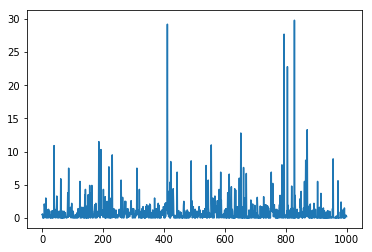

In [153]:
sorted_hist = sorted(hist, key=lambda x: x[0], reverse = False)
values = [elem[1] for elem in sorted_hist]
import matplotlib.pyplot as plt
plt.plot(values)

In [154]:
entropy(values)

tensor(8.3277)

In [159]:
distance_from_uniform(values)

tensor(7.34)

In [ ]:
def make_triplet_samples(z, margin, r2, r3):
  positive_sample = z + random_vector_volume(z.shape, 0, margin).cuda() 
  negative_sample = z + random_vector_volume(z.shape, r2, r3).cuda()
  return positive_sample, negative_sample

def random_vector_surface(shape, r = 1.):
  mat = torch.randn(size=shape).cuda()
  norm = torch.norm(mat, p=2, dim=1, keepdim = True).cuda()
  return (mat/norm) * r

def random_vector_volume(shape, inner_r, outer_r):
  fraction = torch.empty(shape[0]).uniform_(inner_r, outer_r).cuda()
  fraction = ((fraction / outer_r) ** (1 / shape[1])) * outer_r # volume-normalize the fraction
  fraction.unsqueeze_(-1)
  return random_vector_surface(shape, 1) * fraction

In [ ]:
from collections import Counter

def most_frequent(x):
  return Counter(x).most_common(1)[0]

def preds_around(center, radius, n_preds, model, dummy_img):
  z_s = random_vector_volume([n_preds, 10], radius, radius + 0.01) + center[None]
  noises = model.forward_z(z_s)
  perturbed_imgs = noises + dummy_img 
  return torch.argmax(arch(perturbed_imgs), 1)
  
def most_freq_pred_around(center, radius, n_preds, model, dummy_img):
  preds = preds_around(center, radius, n_preds, model, dummy_img)
  most_freq = most_frequent(preds.tolist())
  return (class_index_to_label(most_freq[0]), most_freq[1]/n_preds)

def investigate_neighborhood(z, step, model, dummy_img):
  with torch.no_grad():
    result = []
    for radius in np.arange(0.1, 6., step):
#       print("creating {} more preds".format(int(10 + 5 * (radius ** 2))))
      most_freq_pred = most_freq_pred_around(z, radius, int(10 + 5 * (radius ** 2)), model, dummy_img)
      result.append((radius, most_freq_pred))
    return result

In [ ]:
#experiment 1

z = torch.tensor([0.5] * 10).cuda()
# z = torch.empty(10).uniform_(-1, 1).cuda()
# z_s = z[None]

model = learn.model.eval()
x_img = normalize(learn.data.train_ds[50][0].data.cuda())
  
for i in range(6):
  z = torch.empty(10).uniform_(-1, 1).cuda()
  print("investigation for: ", z)
  for elem in investigate_neighborhood(z, 0.5, model, x_img):
    print(elem)
print("done")

In [ ]:
#experiment 2
import itertools
z_s = [torch.tensor(t).cuda() for t in itertools.product( *([[-0.33, 0.33]] * 10) )]
model = learn.model.eval()
noises = []
with torch.no_grad():
  for z in z_s:
    noises.append(model.forward_single_z(z))

In [ ]:
x_img = normalize(learn.data.train_ds[50][0].data.cuda())

preds = []
for noise in noises:
  perturbed_img = x_img + noise
  preds.append(torch.argmax(arch(perturbed_img[None]), 1)[0].item())

from collections import Counter
result = [(class_index_to_label(index), count) for index, count in Counter(preds).most_common(5)]
result

In [ ]:
#experiment 3
import itertools
dimension_values = [[-0.33, 0.33]] * 10
# dimension_values[0] = [0.]
# dimension_values[3] = [0.]
# dimension_values[6] = [0.]
# dimension_values[9] = [0.]
pruned_z_s = [torch.tensor(t).cuda() for t in itertools.product(*dimension_values)]
model = learn.model.eval()
with torch.no_grad():
  pruned_noises = [model.forward_single_z(z) for z in pruned_z_s]

In [ ]:
results = []
for z, noise in zip(pruned_z_s, pruned_noises):
  hist = compute_prediction_histogram(learn, noise)
  indexed_hist = [(i, val) for i, val in enumerate(hist)]
  sorted_hist = sorted(indexed_hist, key=lambda x: x[1], reverse=True)
  labeled_hist = [(class_index_to_label(i), count) for i, count in sorted_hist]
  results.append((z, labeled_hist[:6]))
  print("new result:")
  print(z)
  print(labeled_hist[:6])
  print("\n\n")

In [ ]:
for noise in pruned_noises[0:500]:
  img = noise_to_image(noise)
  img.show()

In [ ]:
# spider web
z_values = [
  [ 0.33, -0.33,  0.33,  0.33, -0.33,  0.33, -0.33, -0.33, -0.33, -0.33],
  [ 0.33,  0.33, -0.33, -0.33, -0.33,  0.33, -0.33,  0.33, -0.33, -0.33],
  [ 0.33,  0.33, -0.33,  0.33,  0.33, -0.33, -0.33, -0.33,  0.33, -0.33],
  [-0.33, -0.33, -0.33, -0.33, -0.33, -0.33, -0.33, -0.33, -0.33, -0.33],
  [-0.33, -0.33, -0.33, -0.33, -0.33,  0.33,  0.33, -0.33,  0.33,  0.33],
  [-0.33, -0.33, -0.33,  0.33,  0.33, -0.33, -0.33, -0.33, -0.33, -0.33],
  [-0.33, -0.33,  0.33,  0.33, -0.33, -0.33,  0.33, -0.33,  0.33, -0.33],
  [-0.33,  0.33, -0.33,  0.33,  0.33, -0.33,  0.33,  0.33,  0.33,  0.33],
  [-0.33,  0.33,  0.33,  0.33, -0.33, -0.33,  0.33,  0.33, -0.33, -0.33],
  [ 0.33, -0.33, -0.33, -0.33,  0.33,  0.33, -0.33, -0.33, -0.33, -0.33],
  [ 0.33, -0.33,  0.33,  0.33, -0.33, -0.33,  0.33,  0.33, -0.33,  0.33],
  [ 0.33,  0.33, -0.33,  0.33, -0.33, -0.33,  0.33,  0.33, -0.33,  0.33],
  [ 0.33,  0.33,  0.33, -0.33, -0.33, -0.33, -0.33,  0.33, -0.33, -0.33],
  [ 0.33,  0.33,  0.33,  0.33, -0.33, -0.33, -0.33,  0.33, -0.33, -0.33],
  [ 0.33,  0.33,  0.33,  0.33,  0.33,  0.33,  0.33,  0.33,  0.33, -0.33],
  [ 0.33,  0.33,  0.33, -0.33, -0.33, -0.33, -0.33,  0.33,  0.33, -0.33],
]

if any(z_values.count(x) > 1 for x in z_values):
  raise Exception("duplicate")
  
z_s = [torch.tensor(z).cuda() for z in z_values]
model = learn.model.eval()

for z in z_s:
  img = noise_to_image(model.forward_single_z(z))
  img.show()


In [ ]:
z_values = [
  # window screen
  [-0.33,  0.33,  0.33, -0.33, -0.33,  0.33, -0.33, -0.33, -0.33, -0.33],
  [-0.33,  0.33,  0.33, -0.33, -0.33, -0.33, -0.33, -0.33,  0.33,  0.33],
]

if any(z_values.count(x) > 1 for x in z_values):
  raise Exception("duplicate")
  
z_s = [torch.tensor(z).cuda() for z in z_values]
model = learn.model.eval()

for z in z_s:
  img = noise_to_image(model.forward_single_z(z))
  img.show()

In [ ]:
#vgg-16_12 most repeated labels:
l = [(611, 215.0),
  (474, 194.1),
  (398, 120.3),
  (721, 79.6),
  (741, 73.5),
  (510, 62.5)]

[(class_index_to_label(index), count) for index, count in l]

In [ ]:
# learn.recorder.plot_losses()
# learn.recorder.plot_lr()
# learn.recorder.plot_metrics()

In [ ]:
fooling_rates = []
model = learn.model.eval()
learn.metrics = [validation_single_perturbation]
for i in range(10):
  global_perturbations = model(torch.rand(1, 3, 224, 244).cuda())[0]
  nag_util.global_perturbations = global_perturbations
  fooling_rates.append(learn.validate()[1].cpu().item())
  print("%d : %f"%(i, fooling_rates[-1]))

mean = np.mean(fooling_rates)
stddev = np.std(fooling_rates)
print(mean, stddev); print(fooling_rates)

In [ ]:
#the Image works good for floats in range [0..1]
model = learn.model.eval()

x_img = learn.data.train_ds[200][0]
x = normalize(x_img.data.cuda())
z = torch.tensor([-0.33,  0.33, -0.33, -0.33, -0.33,  0.33,  0.33, -0.33, -0.33, -0.33], dtype=torch.float32).cuda()
# z = torch.empty(z_dim).uniform_(-1,1).cuda()
p = model.forward_single_z(z).detach()

p_x = x + p
# print("img range, noise range")
# print_range(x); print_range(p)
adv_label = class_index_to_label(arch(p_x[None]).argmax(1).item())
print_big_vector(arch(p_x[None])[0])
p_x = denormalize(p_x)
p_x.clamp_(0,1)


#prepare images
p_x_img = Image(p_x)
p = scale_to_range(p, [0., 1.])
p_img = Image(p)
x_img.show()
p_img.show()
p_x_img.show()


# print_range(p)
# print_range(denormalize(x))
# print_range(p_x)

benign_label = class_index_to_label(arch(x[None]).argmax(1).item())

print_big_vector(arch(x[None])[0])
print(benign_label, adv_label)

In [ ]:
z1 = torch.tensor([-1, -1, -1, -1, -1, -1, -1, -1, -1, -1], dtype=torch.float32).cuda()
p1 = model.forward_single_z(z1)

z2 = torch.tensor([1, -1, -1, -1, -1, -1, -1, -1, -1, -1], dtype=torch.float32).cuda()
p2 = model.forward_single_z(z2)

z3 = torch.tensor([1, 1, -1, -1, -1, -1, -1, -1, -1, -1], dtype=torch.float32).cuda()
p3 = model.forward_single_z(z3)

l2_distance(p1, p3)

In [ ]:
#the Image works good for floats in range [0..1]
model = learn.model.eval()

x_img = learn.data.train_ds[4][0]
x = x_img.data[None].cuda()
p = model(x)[0].squeeze().detach() 
x = x.squeeze()
x = normalize(x)

p_x = x + p
p_x = denormalize(p_x)
p_x.clamp_(0,1)


#prepare images
p_x_img = Image(p_x)
p = scale_to_range(p, [0.,1.])
p_img = Image(p)
# x_img.show()
p_img.show()
# p_x_img.show()

print_range(p)
print_range(x)
print_range(p_x)